# Part I: Get a list of pubmed ids to add in the unlabeled set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import sys , os 
import urllib, pickle

In [4]:
from pubmed_utils import get_pubmed_citations,get_pubmed_similar_docs

In [5]:
# LOAD from pickle
with open('../my-code/pickles/pubmed_ids_validation.pickle', 'rb') as f:
    pubmed_ids = pickle.load(f)

In [6]:
#define from which ids to take citations/similar articles from
ids = pubmed_ids['validation']+pubmed_ids['train']
print 'Will search for similar documents/citations from %i PubMed articles'%len(ids)

Will search for similar documents/citations from 1632 PubMed articles


In [ ]:
# Explore MESH terms, MESH

In [ ]:

Entrez.email = "amkrasakis@gmail.com"

similar_ids = {}

for i,primary_id in enumerate(ids):
    handle = Entrez.elink(db="pubmed", id=primary_id, cmd="neighbor_score", rettype="xml")
    records = Entrez.read(handle)

    scores = sorted(records[0]['LinkSetDb'][0]['Link'], key=lambda k: int(k['Score']), reverse=True)
    ids = list(map(lambda x: x['Id'],scores[:top_n]))
    scores = list(map(lambda x: int(x['Score']),scores[:top_n]))
    similar_ids.update(dict(zip(ids,scores)))

#     similar_ids.extend(map(lambda x: x['Id'],scores[:top_n]))

    time.sleep(.34) # do not send more than 3 requests/sec
    if i%100==0:
        print 'Getting %i most similar docs to doc %i...'%(top_n, i)

#     return similar_ids

## Get also score

In [6]:
similar_dict = get_pubmed_similar_docs(ids,top_n=25)

Getting 25 most similar docs to doc 0...
Getting 25 most similar docs to doc 100...
Getting 25 most similar docs to doc 200...
Getting 25 most similar docs to doc 300...
Getting 25 most similar docs to doc 400...
Getting 25 most similar docs to doc 500...
Getting 25 most similar docs to doc 600...
Getting 25 most similar docs to doc 700...
Getting 25 most similar docs to doc 800...
Getting 25 most similar docs to doc 900...
Getting 25 most similar docs to doc 1000...
Getting 25 most similar docs to doc 1100...
Getting 25 most similar docs to doc 1200...
Getting 25 most similar docs to doc 1300...
Getting 25 most similar docs to doc 1400...
Getting 25 most similar docs to doc 1500...
Getting 25 most similar docs to doc 1600...


In [31]:
# # write in pickle
# with open('/home/antonis/data/biocreative6/pubmed_ids_25similar_scores.pickle', 'wb') as f:
#     pickle.dump(similar_dict,f)

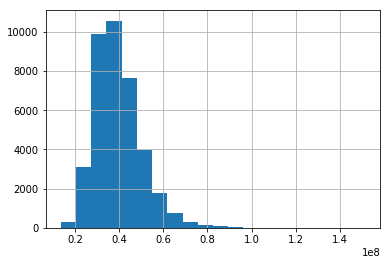

In [10]:
pd.Series(similar_dict.values()).hist(bins=20)

In [11]:
scores_ser = pd.Series(similar_dict.values())

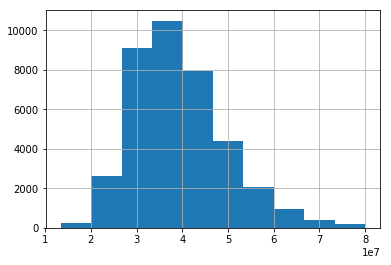

In [23]:
scores_ser[scores_ser<8e7].hist()

In [29]:
(scores_ser<5e7).value_counts()

True     32891
False     5650
dtype: int64

In [30]:
ids[0]

'22989703'

In [33]:
# get the ids of these 

In [39]:
ids5 = list(int(k) for k, v in similar_dict.items() if v >= 5e7)

In [41]:
len(ids5)

5650

In [42]:
# write in pickle
with open('/home/antonis/data/biocreative6/pubmed_ids_5e7similarity.pickle', 'wb') as f:
    pickle.dump(ids5,f)

## Get ids of *similar abstracts*

In [5]:
# pubmed_ids['similar25'] = get_pubmed_similar_docs(ids,top_n=25) # old code

Getting 25 most similar docs to doc 0...
Getting 25 most similar docs to doc 100...
Getting 25 most similar docs to doc 200...
Getting 25 most similar docs to doc 300...
Getting 25 most similar docs to doc 400...
Getting 25 most similar docs to doc 500...
Getting 25 most similar docs to doc 600...
Getting 25 most similar docs to doc 700...
Getting 25 most similar docs to doc 800...
Getting 25 most similar docs to doc 900...
Getting 25 most similar docs to doc 1000...
Getting 25 most similar docs to doc 1100...
Getting 25 most similar docs to doc 1200...
Getting 25 most similar docs to doc 1300...
Getting 25 most similar docs to doc 1400...
Getting 25 most similar docs to doc 1500...
Getting 25 most similar docs to doc 1600...


In [6]:
# delete from citations documents contained on train,dev, test set

print '# similar docs retrieved:',len(pubmed_ids['similar25'])
pubmed_ids['similar25'] = list(set(pubmed_ids['similar25']) - set(pubmed_ids['validation'] + pubmed_ids['train'] + pubmed_ids['test_gs']))
print '# similar docs without overlap with train/val:',len(pubmed_ids['similar25'])


# similar docs retrieved: 38541
# similar docs without overlap with train/val: 38311


In [7]:
pubmed_ids.keys()

['incoming_citations',
 'test_gs',
 'outgoing_citations',
 'train',
 'similar25',
 'validation']

In [8]:
# save to pickle
with open('/home/antonis/data/biocreative6/pubmed_ids_similar25.pickle', 'wb') as f:
    pickle.dump(pubmed_ids, f)

## Get ids of *citations*

In [ ]:
pubmed_ids['outgoing_citations'] = get_pubmed_citations(ids,outgoing = True)
pubmed_ids['incoming_citations'] = get_pubmed_citations(ids,outgoing = False)


In [62]:
pubmed_ids.keys()

['development',
 'incoming_citations',
 'training',
 'test_gs',
 'outgoing_citations',
 'chemdner_silver']

### delete from citations documents contained on train,dev, test set

In [15]:
print '# outgoing_citations:',len(pubmed_ids['outgoing_citations'])
pubmed_ids['outgoing_citations'] = list(set(pubmed_ids['outgoing_citations']) - set(pubmed_ids['development'] + pubmed_ids['training'] + pubmed_ids['test_gs']))
print '# outgoing_citations without overlap with train/test/dev:',len(pubmed_ids['outgoing_citations'])

print '# incoming_citations:',len(pubmed_ids['incoming_citations'])
pubmed_ids['incoming_citations'] = list(set(pubmed_ids['incoming_citations']) - set(pubmed_ids['development'] + pubmed_ids['training'] + pubmed_ids['test_gs']))
print '# incoming_citations without overlap with train/test/dev:',len(pubmed_ids['incoming_citations'])


# outgoing_citations: 22973
# outgoing_citations without overlap with traintestdev: 22251
# incoming_citations: 29059
# incoming_citations without overlap with traintestdev: 27546


In [16]:
with open('/home/antonis/data/biocreative6/pubmed_ids_citations.pickle', 'wb') as f:
    pickle.dump(pubmed_ids, f)

In [64]:
# Check some of the articles

In [65]:
# import random
# # get article link
# print 'https://www.ncbi.nlm.nih.gov/pubmed/?term='+citations[random.randint(0,len(citations))]
# # get article entities
# print "https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/RESTful/tmTool.cgi/Bioconcept/%s/PubTator/"%citations[random.randint(0,len(citations))]


# Part II: Parse selected abstract + their NER tags

In [9]:
import sys , os, urllib, random, time

In [10]:
# load from pickle
with open('/home/antonis/data/biocreative6/pubmed_ids_similar25.pickle', 'rb') as f:
    pubmed_ids = pickle.load(f)

In [11]:
pubmed_ids.keys()

['incoming_citations',
 'test_gs',
 'outgoing_citations',
 'train',
 'similar25',
 'validation']

In [12]:
split_type = 'similar25'
bioconcept = 'Bioconcept' # includes all formats (genes, chemicals, diseases...)
api_output_loc = 'temp/NCBI_downloaded.txt'

In [14]:
# Get only a subset for starters
docs2retrieve = pubmed_ids[split_type] # or get a sample of it
# docs2retrieve = [ pubmed_ids[split_type][i] for i in sorted(random.sample(xrange(len(pubmed_ids[split_type])), 10000)) ]


In [31]:
print 'Will parse %i docs from %s set'%(len(docs2retrieve),split_type)
format = 'PubTator'

Will parse 38311 docs from similar25 set


In [25]:
# set Pubtator converter options
out_format = 'standoff'
data_path = '/home/antonis/data/biocreative6/NCBI_parsed/'
out_dir = os.path.join(data_path, split_type)
print "Will save in ", out_dir

Will save in  /home/antonis/data/biocreative6/NCBI_parsed/similar25


In [17]:
# import pubtator conversion script
sys.path.append('/home/antonis/ipythonNotebooks/snorkel-ml/helpers/pubtator/')
import convertpubtator

class arg_options:
    '''
    Class to overwrite pubtators tool main argument parser.
    '''
    def __init__(self, files, out_dir = out_dir , out_format='standoff', ids = None, ):
        self.ids = ids
        self.output = out_dir
        self.random = None
        self.segment = False
        self.files = files
        self.format = out_format
        self.no_text = False
        self.subdirs = False

# set conversion options
options = arg_options(files = api_output_loc, ids = None, out_format= 'standoff')

In [18]:
# Start downloading

In [33]:
n=199 #split to chunks
st_time = time.time()

for i in xrange(0,len(docs2retrieve), n):
    
    print 'Parsing docs %i to %i  . . . .'%(i+1,i+n+1)
    
    pmids = ','.join(docs2retrieve[i:i+n])
    
    all_pmids
#     print pmids
    
    # Calculate how much time to wait (avoid reaching pubmed API limits ~ 3 requests/sec )
    time_elapsed = time.time() - st_time
    if time_elapsed<0.34:
        time.sleep(0.34 - time_elapsed)
    
    url_Submit = "https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/RESTful/tmTool.cgi/%s/%s/%s/"%(bioconcept,pmids,format)
    urllib.urlretrieve(url_Submit, api_output_loc)
    
    st_time = time.time() #refresh time

    print 'Converting from PubTator to BRAT'
    convertpubtator.convert(api_output_loc, convertpubtator.write_standoff, options = options)

Parsing docs 1 to 200  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 200 to 399  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 399 to 598  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 598 to 797  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 797 to 996  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 996 to 1195  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 1195 to 1394  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 1394 to 1593  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 1593 to 1792  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 1792 to 1991  . . . .
Converting from PubTator to BRAT
Parsing docs 1991 to 2190  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 2190 to 2389  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 2389 to 2588  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 2588 to 2787  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 2787 to 2986  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 2986 to 3185  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 3185 to 3384  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 3384 to 3583  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 3583 to 3782  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 3782 to 3981  . . . .
Converting from PubTator to BRAT
Parsing docs 3981 to 4180  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT
Parsing docs 4180 to 4379  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 4379 to 4578  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 4578 to 4777  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 4777 to 4976  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 4976 to 5175  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 5175 to 5374  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 5374 to 5573  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 5573 to 5772  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 5772 to 5971  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 5971 to 6170  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 6170 to 6369  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 6369 to 6568  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 6568 to 6767  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 6767 to 6966  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 6966 to 7165  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 7165 to 7364  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 7364 to 7563  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 7563 to 7762  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 7762 to 7961  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 7961 to 8160  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 8160 to 8359  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 8359 to 8558  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 8558 to 8757  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 8757 to 8956  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 8956 to 9155  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 9155 to 9354  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 9354 to 9553  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 9553 to 9752  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 9752 to 9951  . . . .
Converting from PubTator to BRAT
Parsing docs 9951 to 10150  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 10150 to 10349  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 10349 to 10548  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 10548 to 10747  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 10747 to 10946  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 10946 to 11145  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 11145 to 11344  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 11344 to 11543  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 11543 to 11742  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 11742 to 11941  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 11941 to 12140  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 12140 to 12339  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 12339 to 12538  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 12538 to 12737  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 12737 to 12936  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 12936 to 13135  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 13135 to 13334  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 13334 to 13533  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 13533 to 13732  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 13732 to 13931  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 13931 to 14130  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 14130 to 14329  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 14329 to 14528  . . . .
Converting from PubTator to BRAT
Parsing docs 14528 to 14727  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 14727 to 14926  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 14926 to 15125  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 15125 to 15324  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 15324 to 15523  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 15523 to 15722  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 15722 to 15921  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 15921 to 16120  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 16120 to 16319  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 16319 to 16518  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 16518 to 16717  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 16717 to 16916  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 16916 to 17115  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 17115 to 17314  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 17314 to 17513  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 17513 to 17712  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 17712 to 17911  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 17911 to 18110  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 18110 to 18309  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 18309 to 18508  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 18508 to 18707  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 18707 to 18906  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 18906 to 19105  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 19105 to 19304  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 19304 to 19503  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 19503 to 19702  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 19702 to 19901  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 19901 to 20100  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 20100 to 20299  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 20299 to 20498  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 20498 to 20697  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 20697 to 20896  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 20896 to 21095  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 21095 to 21294  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 21294 to 21493  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 21493 to 21692  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 21692 to 21891  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 21891 to 22090  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 22090 to 22289  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 22289 to 22488  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 22488 to 22687  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 22687 to 22886  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 22886 to 23085  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 23085 to 23284  . . . .
Converting from PubTator to BRAT
Parsing docs 23284 to 23483  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 23483 to 23682  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 23682 to 23881  . . . .
Converting from PubTator to BRAT
Parsing docs 23881 to 24080  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 24080 to 24279  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 24279 to 24478  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 24478 to 24677  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 24677 to 24876  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 24876 to 25075  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 25075 to 25274  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 25274 to 25473  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 25473 to 25672  . . . .
Converting from PubTator to BRAT
Parsing docs 25672 to 25871  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 25871 to 26070  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 26070 to 26269  . . . .
Converting from PubTator to BRAT
Parsing docs 26269 to 26468  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT
Parsing docs 26468 to 26667  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 26667 to 26866  . . . .
Converting from PubTator to BRAT
Parsing docs 26866 to 27065  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 27065 to 27264  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 27264 to 27463  . . . .
Converting from PubTator to BRAT
Parsing docs 27463 to 27662  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 27662 to 27861  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 27861 to 28060  . . . .
Converting from PubTator to BRAT
Parsing docs 28060 to 28259  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 28259 to 28458  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 28458 to 28657  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 28657 to 28856  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 28856 to 29055  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 29055 to 29254  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 29254 to 29453  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 29453 to 29652  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 29652 to 29851  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 29851 to 30050  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 30050 to 30249  . . . .
Converting from PubTator to BRAT
Parsing docs 30249 to 30448  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 30448 to 30647  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 30647 to 30846  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 30846 to 31045  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 31045 to 31244  . . . .
Converting from PubTator to BRAT
Parsing docs 31244 to 31443  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 31443 to 31642  . . . .
Converting from PubTator to BRAT
Parsing docs 31642 to 31841  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT
Parsing docs 31841 to 32040  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT
Parsing docs 32040 to 32239  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 32239 to 32438  . . . .
Converting from PubTator to BRAT
Parsing docs 32438 to 32637  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 32637 to 32836  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 32836 to 33035  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 33035 to 33234  . . . .
Converting from PubTator to BRAT
Parsing docs 33234 to 33433  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT
Parsing docs 33433 to 33632  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 33632 to 33831  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 33831 to 34030  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 34030 to 34229  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 34229 to 34428  . . . .
Converting from PubTator to BRAT
Parsing docs 34428 to 34627  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT
Parsing docs 34627 to 34826  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 34826 to 35025  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 35025 to 35224  . . . .
Converting from PubTator to BRAT
Parsing docs 35224 to 35423  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 35423 to 35622  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 35622 to 35821  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 35821 to 36020  . . . .
Converting from PubTator to BRAT
Parsing docs 36020 to 36219  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 36219 to 36418  . . . .
Converting from PubTator to BRAT
Parsing docs 36418 to 36617  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 36617 to 36816  . . . .
Converting from PubTator to BRAT
Parsing docs 36816 to 37015  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT
Parsing docs 37015 to 37214  . . . .


Processed 100 documents ...
Done, processed 199 documents.


Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 37214 to 37413  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 37413 to 37612  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 37612 to 37811  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 37811 to 38010  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 38010 to 38209  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 199 documents.


Parsing docs 38209 to 38408  . . . .
Converting from PubTator to BRAT


Processed 100 documents ...
Done, processed 103 documents.
